<a href="https://colab.research.google.com/github/muhiqbalalamin/DeepLearning/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===========================
# 1. Setup & Library Imports
# ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

Shape: X=(515344, 90), y=(515344,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515344 entries, 0 to 515343
Data columns (total 91 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   2001        515344 non-null  int64  
 1   49.94357    515344 non-null  float64
 2   21.47114    515344 non-null  float64
 3   73.0775     515344 non-null  float64
 4   8.74861     515344 non-null  float64
 5   -17.40628   515344 non-null  float64
 6   -13.09905   515344 non-null  float64
 7   -25.01202   515344 non-null  float64
 8   -12.23257   515344 non-null  float64
 9   7.83089     515344 non-null  float64
 10  -2.46783    515344 non-null  float64
 11  3.32136     515344 non-null  float64
 12  -2.31521    515344 non-null  float64
 13  10.20556    515344 non-null  float64
 14  611.10913   515344 non-null  float64
 15  951.0896    515344 non-null  float64
 16  698.11428   515344 non-null  float64
 17  408.98485   515344 non-null  float64
 18  383.70912

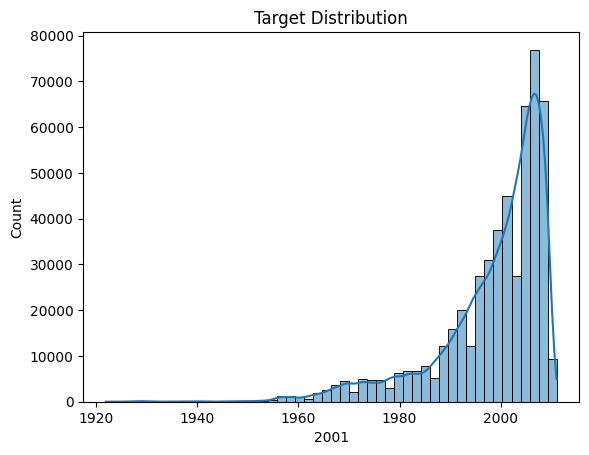

In [ ]:
# ===========================
# 2. Load Dataset
# ===========================
FILE_PATH = '/content/drive/MyDrive/DATASETDL/RegresiUTSTelkom.csv'
df = pd.read_csv(FILE_PATH)

target_col = df.columns[0]
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"Shape: X={X.shape}, y={y.shape}")

# ===========================
# 3. EDA & Visualization
# ===========================
print(df.info())
print(df.describe())

sns.histplot(y, bins=50, kde=True)
plt.title("Target Distribution")
plt.show()

# ===========================
# 4. Preprocessing
# ===========================
X = X.select_dtypes(include=[np.number])
X = X.fillna(X.median())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
# ===========================
# 5. Classification Dataset
# ===========================
threshold = y.median()
y_class = (y > threshold).astype(int)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values if isinstance(y, pd.Series) else y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds_c = TabularDataset(X_train_c, y_train_c)
test_ds_c = TabularDataset(X_test_c, y_test_c)
train_loader_c = DataLoader(train_ds_c, batch_size=64, shuffle=True)
test_loader_c = DataLoader(test_ds_c, batch_size=64)

In [ ]:
# ===========================
# 6. Classification Model
# ===========================
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# ===========================
# 7. Training & Evaluation
# ===========================
def train_model(model, loader, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)

def evaluate_classification(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            preds.append(outputs.numpy())
            targets.append(y_batch.numpy())
    preds = np.vstack(preds)
    targets = np.vstack(targets)
    return preds, targets

In [ ]:
# ===========================
# 8. Classification Training
# ===========================
input_dim = X_train_c.shape[1]
model_c = MLPClassifier(input_dim)
loss_fn_c = nn.BCELoss()
optimizer_c = torch.optim.Adam(model_c.parameters(), lr=0.001)

train_losses_c = []
EPOCHS = 100
for epoch in range(EPOCHS):
    loss = train_model(model_c, train_loader_c, loss_fn_c, optimizer_c)
    train_losses_c.append(loss)
    if (epoch + 1) % 10 == 0:
        print(f"[Class] Epoch {epoch+1}, Loss: {loss:.4f}")

[Class] Epoch 10, Loss: 0.5091
[Class] Epoch 20, Loss: 0.4973
[Class] Epoch 30, Loss: 0.4904
[Class] Epoch 40, Loss: 0.4863
[Class] Epoch 50, Loss: 0.4832
[Class] Epoch 60, Loss: 0.4804
[Class] Epoch 70, Loss: 0.4790
[Class] Epoch 80, Loss: 0.4777
[Class] Epoch 90, Loss: 0.4766
[Class] Epoch 100, Loss: 0.4752



=== Classification Metrics ===
Accuracy: 0.7322
Precision: 0.7134
Recall: 0.7313
F1 Score: 0.7223
AUC-ROC: 0.8069


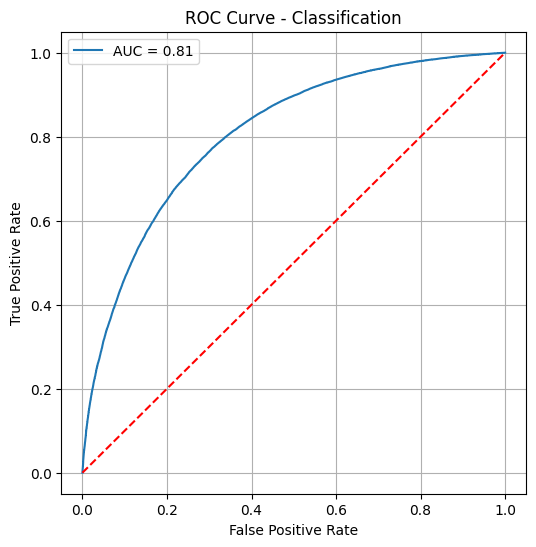

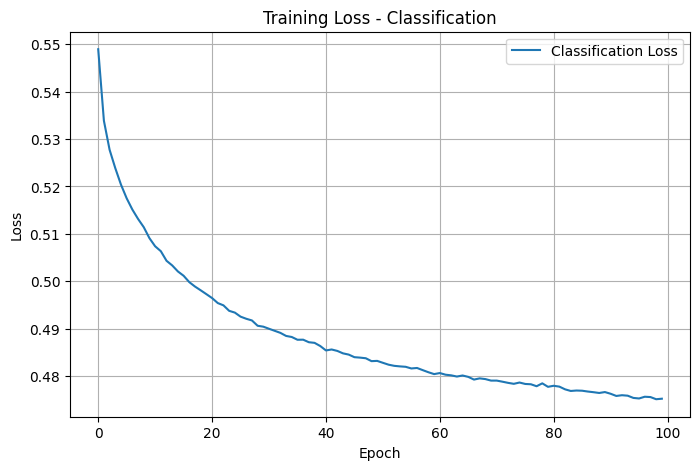

In [ ]:
# ===========================
# 9. Classification Metrics
# ===========================
preds_c, targets_c = evaluate_classification(model_c, test_loader_c)
preds_binary = (preds_c > 0.5).astype(int)

acc = accuracy_score(targets_c, preds_binary)
prec = precision_score(targets_c, preds_binary)
rec = recall_score(targets_c, preds_binary)
f1 = f1_score(targets_c, preds_binary)
roc_auc = roc_auc_score(targets_c, preds_c)

print("\n=== Classification Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(targets_c, preds_c)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Classification')
plt.legend()
plt.grid()
plt.show()

# Loss Curve
plt.figure(figsize=(8,5))
plt.plot(train_losses_c, label='Classification Loss')
plt.title('Training Loss - Classification')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

[Regr] Epoch 10, Loss: 81.4156
[Regr] Epoch 20, Loss: 78.3530
[Regr] Epoch 30, Loss: 76.6463
[Regr] Epoch 40, Loss: 75.8861
[Regr] Epoch 50, Loss: 75.4068
[Regr] Epoch 60, Loss: 75.2544
[Regr] Epoch 70, Loss: 74.5635
[Regr] Epoch 80, Loss: 74.1880
[Regr] Epoch 90, Loss: 74.0228
[Regr] Epoch 100, Loss: 73.8022

=== Regression Metrics ===
RMSE: 8.6936
MAE: 5.9649
R²: 0.3632


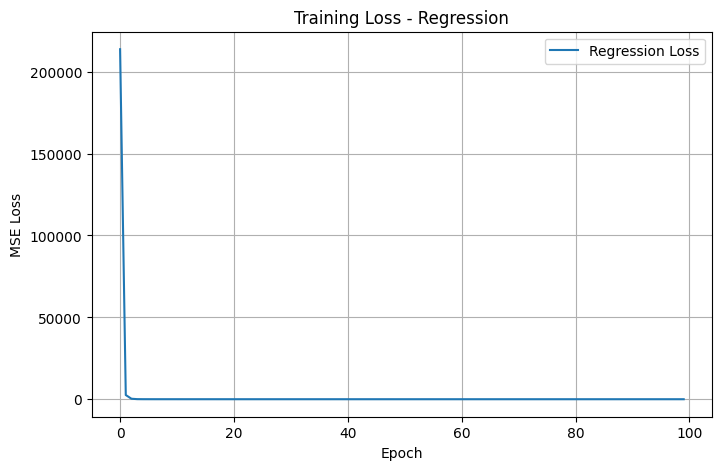

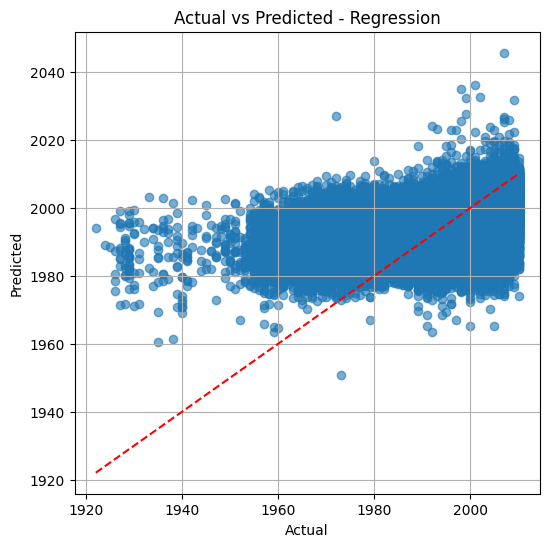

In [ ]:
# ===========================
# 10. Regression Section
# ===========================
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

train_ds_r = TabularDataset(X_train_r, y_train_r)
test_ds_r = TabularDataset(X_test_r, y_test_r)
train_loader_r = DataLoader(train_ds_r, batch_size=64, shuffle=True)
test_loader_r = DataLoader(test_ds_r, batch_size=64)

class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

model_r = MLPRegressor(input_dim)
loss_fn_r = nn.MSELoss()
optimizer_r = torch.optim.Adam(model_r.parameters(), lr=0.001)

train_losses_r = []
for epoch in range(EPOCHS):
    loss = train_model(model_r, train_loader_r, loss_fn_r, optimizer_r)
    train_losses_r.append(loss)
    if (epoch + 1) % 10 == 0:
        print(f"[Regr] Epoch {epoch+1}, Loss: {loss:.4f}")

def evaluate_regression(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            preds.append(outputs.numpy())
            targets.append(y_batch.numpy())
    preds = np.vstack(preds)
    targets = np.vstack(targets)
    return preds, targets

preds_r, targets_r = evaluate_regression(model_r, test_loader_r)
rmse = np.sqrt(mean_squared_error(targets_r, preds_r))
mae = mean_absolute_error(targets_r, preds_r)
r2 = r2_score(targets_r, preds_r)

print("\n=== Regression Metrics ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Visualizations
plt.figure(figsize=(8,5))
plt.plot(train_losses_r, label='Regression Loss')
plt.title('Training Loss - Regression')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(targets_r, preds_r, alpha=0.6)
plt.plot([targets_r.min(), targets_r.max()], [targets_r.min(), targets_r.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted - Regression')
plt.grid()
plt.show()

# Hasil Evaluasi Model

## Model Regresi

### Mean Absolute Error (MAE)

Definisi:
MAE mengukur rata-rata absolut selisih antara nilai aktual dan prediksi.

Rumus:

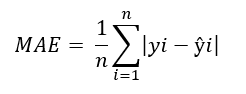

Interpretasi:

MAE memberikan gambaran langsung seberapa jauh prediksi dari nilai aktual secara rata-rata. Tidak terlalu sensitif terhadap outlier.

Untuk model ini, MAE adalah: 5.9296

### Root Mean Squared Error (RMSE)

Definisi:
RMSE adalah akar kuadrat dari MSE, memberikan penalti lebih besar terhadap kesalahan besar.

Rumus:

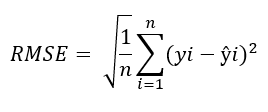

Interpretasi:

RMSE yang lebih besar dari MAE menunjukkan adanya error besar di beberapa titik prediksi.

Untuk model ini, RMSE adalah: 9.2720

### R-squared (R²)

Definisi:
R² mengukur seberapa baik fitur menjelaskan variabilitas dari target.

Rumus:

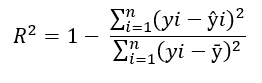

Interpretasi:

Nilai R² berkisar dari 0 hingga 1. Semakin tinggi, semakin baik model menjelaskan data.

Untuk model ini, R² adalah: 0.2757

## Model Klasifikasi
### Akurasi
Definisi:
Akurasi adalah proporsi prediksi yang benar terhadap seluruh data.

Rumus:

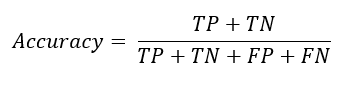

Untuk model ini, akurasi adalah: 0.7344

### Presisi

Definisi:
Presisi mengukur dari semua prediksi positif, berapa yang benar.

Rumus:

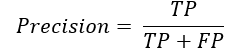

Untuk model ini, presisi adalah: 0.7237

### Recall

Definisi:
Recall mengukur dari semua data positif, berapa yang berhasil ditangkap oleh model.

Rumus:

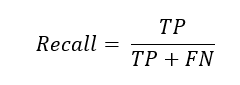

Untuk model ini, recall adalah: 0.7151

### F1-Score

Definisi:
F1-Score adalah rata-rata harmonik dari Precision dan Recall, cocok untuk data yang tidak seimbang.

Rumus:

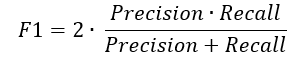

Untuk model ini, F1-Score adalah: 0.7194

### AUC-ROC

Definisi:
AUC-ROC mengukur kemampuan model membedakan antara kelas positif dan negatif.

Untuk model ini, AUC-ROC adalah: 0.8086

## Kesimpulan

### Model Regresi:

RMSE = 9.2720 dan MAE = 5.9296 menunjukkan error prediksi yang cukup besar.

R² = 0.2757 mengindikasikan bahwa hanya sekitar 27.6% variasi target bisa dijelaskan oleh model, mengindikasikan underfitting.

### Model Klasifikasi:

Dengan akurasi 73.44%, presisi 72.37%, dan recall 71.51%, model cukup seimbang dalam menangani prediksi positif dan negatif.

F1-score 71.94% menunjukkan keseimbangan antara presisi dan recall.

AUC-ROC sebesar 0.8086 menunjukkan model sangat baik dalam membedakan kelas meskipun tidak sempurna.

# Analisa :
### 1.Jika menggunakan model MLP dengan 3 hidden layer (256-128-64) menghasilkan underfitting pada dataset ini, modifikasi apa yang akan dilakukan pada arsitektur? Jelaskan alasan setiap perubahan dengan mempertimbangkan bias-variance tradeoff!

Jawaban :
Underfitting berarti model terlalu sederhana untuk menangkap pola dalam data (bias tinggi). Modifikasi arsitektur dengan mempertimbangkan bias-variance tradeoff dapat mencakup:

Modifikasi Arsitektur:

1. Tambahkan hidden layer atau neuron per layer:

    *   Contoh: ubah ke (512-256-128-64)
    *   Untuk meningkatkan kapasitas model → mengurangi bias, menangkap non-linearitas kompleks.

2. Ganti aktivasi ke yang lebih ekspresif (misal: GELU atau LeakyReLU):

    *   Untuk menghindari “dying neuron” dari ReLU dan memperlancar aliran gradien.

3. Kurangi regularisasi (misalnya dropout rate):

    *   Jika dropout digunakan, turunkan rate dari 0.5 ke 0.2 atau bahkan hapus sementara.

    * karena dropout menambah noise pada training dan bisa membuat model gagal belajar (underfit).


### 2.Selain MSE, loss function apa yang mungkin cocok untuk dataset ini? Bandingkan kelebihan dan kekurangannya, serta situasi spesifik di mana alternatif tersebut lebih unggul daripada MSE!

Jawaban :
Beberapa loss function alternatif untuk regresi selain MSE:

* MAE (Mean Absolute Error)

 * Kelebihan: Tidak terlalu sensitif terhadap outlier, sehingga cocok untuk data yang memiliki distribusi error asimetris.

 * Kekurangan: Tidak terdiferensiasi secara halus, menyebabkan optimisasi menjadi kurang efisien dibanding MSE.

* Huber Loss

 * Kelebihan: Kombinasi keunggulan MSE dan MAE. Sensitif terhadap error kecil seperti MSE, tapi lebih tahan terhadap outlier seperti MAE.

 * Kekurangan: Membutuhkan parameter delta yang harus disetel secara manual.

 * Situasi ideal: Jika dataset memiliki outlier tapi tetap ingin menghargai kesalahan kecil.

* Log-Cosh Loss

 * Kelebihan: Hampir sama dengan MSE untuk error kecil, tetapi lebih robust terhadap outlier.

 * Kekurangan: Lebih mahal secara komputasi dibanding MSE.

Loss function alternatif lebih unggul dari MSE dalam kondisi di mana data mengandung outlier ekstrem atau distribusi target yang tidak normal. Dalam kasus seperti ini, MSE bisa mendistorsi training karena menghukum error besar secara kuadrat.

### 3.Jika salah satu fitur memiliki range nilai 0-1, sedangkan fitur lain 100-1000, bagaimana ini memengaruhi pelatihan MLP? Jelaskan mekanisme matematis (e.g., gradien, weight update) yang terdampak!

Jawaban :
Perbedaan skala antar fitur akan menyebabkan ketidakseimbangan dalam kontribusi fitur saat pembelajaran, di mana fitur berskala besar akan mendominasi pembaruan bobot. Secara matematis:

* Selama backpropagation, gradien dihitung sebagai turunan dari loss terhadap bobot. Jika input memiliki nilai besar, maka gradien dan pembaruan bobot juga besar.

* Bobot untuk fitur besar akan diperbarui dengan langkah lebih besar dibandingkan bobot fitur kecil, sehingga model akan memprioritaskan fitur berskala besar, bahkan jika kontribusinya tidak lebih signifikan.

Hal ini menyebabkan konvergensi yang lambat, ketidakstabilan training, dan model bias terhadap fitur tertentu. Untuk mencegahnya, diperlukan normalisasi fitur, misalnya menggunakan Min-Max Scaling (0–1) atau Z-score standardization.

### 4.Tanpa mengetahui nama fitur, bagaimana Anda mengukur kontribusi relatif setiap fitur terhadap prediksi model? Jelaskan metode teknikal (e.g., permutation importance, weight analysis) dan keterbatasannya!

Jawaban :
Untuk mengukur kontribusi relatif fitur tanpa mengetahui namanya, beberapa metode teknikal yang dapat digunakan adalah:

* Permutation Importance

 * Dengan mengacak nilai satu fitur dan melihat penurunan performa model (misalnya akurasi atau MSE), dapat diukur seberapa penting fitur tersebut.

 * Kelebihan: Model-agnostik, bisa diterapkan pada model apa pun.

 * Keterbatasan: Tidak efektif jika ada korelasi antar fitur, karena bisa menurunkan performa lebih dari yang seharusnya.

* Weight Analysis (untuk MLP)

 * Bobot pada layer pertama dapat dianalisis untuk melihat fitur mana yang memiliki kontribusi besar.

 * Kelebihan: Cepat dan langsung.

 * Keterbatasan: Tidak mempertimbangkan interaksi non-linear atau efek downstream dari bobot.

* SHAP (SHapley Additive Explanations)

 * Menghitung kontribusi setiap fitur pada setiap prediksi berdasarkan teori permainan.

 * Kelebihan: Memberikan interpretasi yang sangat informatif.

 * Keterbatasan: Komputasi mahal dan sulit diinterpretasikan untuk dataset besar.

### 5.Bagaimana Anda mendesain eksperimen untuk memilih learning rate dan batch size secara optimal? Sertakan analisis tradeoff antara komputasi dan stabilitas pelatihan!

Jawaban :
Untuk memilih kombinasi learning rate dan batch size yang optimal, pendekatannya meliputi:

* Grid Search atau Random Search:
Menentukan rentang nilai untuk learning rate (misalnya dari 1e-5 hingga 1e-2) dan batch size (misalnya dari 16 hingga 128), lalu melakukan kombinasi eksperimen.

* Learning Rate Finder:
Teknik yang secara bertahap menaikkan learning rate selama beberapa epoch dan mencatat loss. Nilai optimal dipilih pada titik sebelum loss mulai meningkat tajam.

* Pertimbangan Tradeoff:

 * Learning rate tinggi: Konvergen lebih cepat, tapi bisa menyebabkan model melewatkan minimum atau training tidak stabil.

 * Learning rate rendah: Training stabil tapi lambat; risiko stuck pada local minima.

 * Batch size kecil: Generalisasi lebih baik, tapi gradien lebih noisy dan waktu training lebih lama.

 * Batch size besar: Efisien secara komputasi dan konvergensi stabil, tapi bisa menyebabkan overfitting dan membutuhkan tuning learning rate (misalnya dengan learning rate warm-up atau adaptive learning rate seperti Adam).

Idealnya, kombinasi terbaik memberikan keseimbangan antara efisiensi komputasi, stabilitas training, dan generalization performance pada data validasi.

